In [1]:
import sqlite3
import pandas as pd

conn = sqlite3.connect("../retail_sales_analytics.db")

query = """
WITH customer_orders AS (
    SELECT
        c.customer_unique_id,
        o.order_id,
        o.order_purchase_timestamp,
        p.payment_value
    FROM customers c
    JOIN orders o ON c.customer_id = o.customer_id
    JOIN payments p ON o.order_id = p.order_id
),
rfm_base AS (
    SELECT
        customer_unique_id,
        MAX(order_purchase_timestamp) AS last_purchase_date,
        COUNT(DISTINCT order_id) AS frequency,
        SUM(payment_value) AS monetary
    FROM customer_orders
    GROUP BY customer_unique_id
)
SELECT
    customer_unique_id,
    JULIANDAY((SELECT MAX(order_purchase_timestamp) FROM orders))
    - JULIANDAY(last_purchase_date) AS recency,
    frequency,
    monetary
FROM rfm_base;
"""

rfm = pd.read_sql_query(query, conn)
rfm.head()


,customer_unique_id,recency,frequency,monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,160.273507,1,141.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,163.263090,1,27.19
2,0000f46a3911fa3c0805444483337064,585.850868,1,86.22
3,0000f6ccb0745a6a4b88665a16c9f078,369.875428,1,43.62
4,0004aac84e0df4da2b147fca70cf8255,336.905972,1,196.89


In [2]:
rfm["R"] = pd.qcut(rfm["recency"], 4, labels=[4,3,2,1])
rfm["F"] = pd.qcut(rfm["frequency"].rank(method="first"), 4, labels=[1,2,3,4])
rfm["M"] = pd.qcut(rfm["monetary"], 4, labels=[1,2,3,4])


In [3]:
rfm["RFM_Score"] = (
    rfm["R"].astype(int) +
    rfm["F"].astype(int) +
    rfm["M"].astype(int)
)

In [4]:
def segment(score):
    if score >= 10:
        return "Champions"
    elif score >= 7:
        return "Potential Loyalists"
    elif score >= 5:
        return "At Risk"
    else:
        return "Low Value"

rfm["Segment"] = rfm["RFM_Score"].apply(segment)

In [5]:
rfm["Segment"].value_counts()

Segment
Potential Loyalists    50030
At Risk                24139
Champions              15618
Low Value               6308
Name: count, dtype: int64

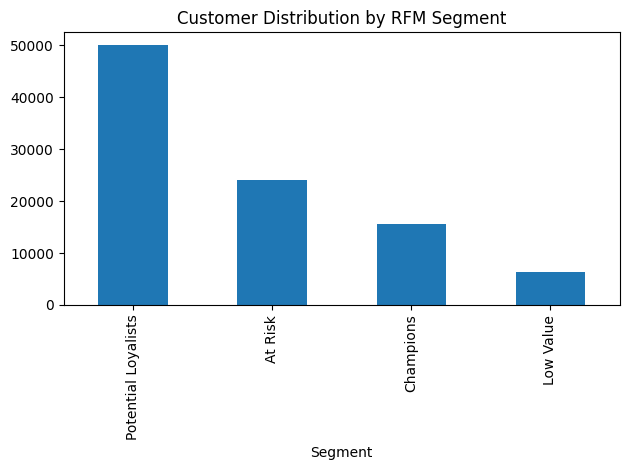

In [6]:
import matplotlib.pyplot as plt

segment_counts = rfm["Segment"].value_counts()

plt.figure()
segment_counts.plot(kind="bar")
plt.title("Customer Distribution by RFM Segment")
plt.tight_layout()
plt.savefig("../visuals/rfm_segment_distribution.png")
plt.show()


In [9]:
#A large portion of customers are "Potential Loyalists", but struggles to convert them into repeat high-value customers (i.e. small "Champion" segment and a sizable "at-risk" group)

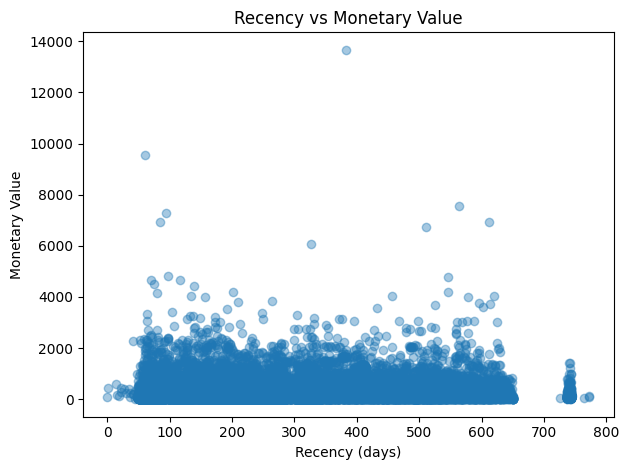

In [7]:
plt.figure()
plt.scatter(rfm["recency"], rfm["monetary"], alpha=0.4)
plt.xlabel("Recency (days)")
plt.ylabel("Monetary Value")
plt.title("Recency vs Monetary Value")
plt.tight_layout()
plt.savefig("../visuals/recency_vs_monetary.png")
plt.show()


In [10]:
#high-value customers are spread out throughout different recency levels, i.e. inactive but historically valuable customers

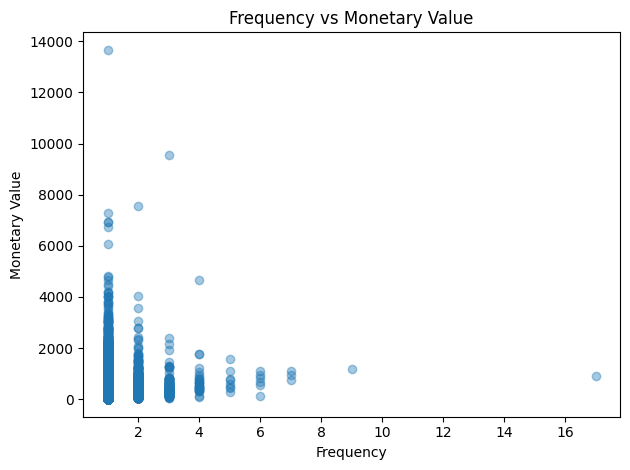

In [11]:
plt.figure()
plt.scatter(rfm["frequency"], rfm["monetary"], alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Monetary Value")
plt.title("Frequency vs Monetary Value")
plt.tight_layout()
plt.savefig("../visuals/frequency_vs_monetary.png")
plt.show()


In [13]:
#Rather than a single loyalty pattern, high customer value is driven by both infrequent high-ticket purchases and moderately frequent repeat purchases

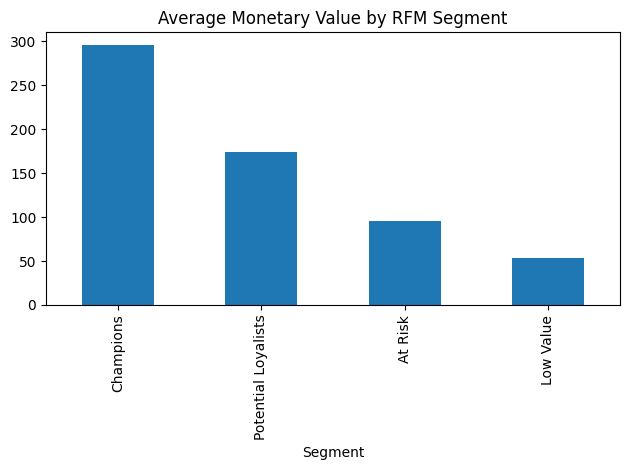

In [12]:
avg_monetary = rfm.groupby("Segment")["monetary"].mean().sort_values(ascending=False)

plt.figure()
avg_monetary.plot(kind="bar")
plt.title("Average Monetary Value by RFM Segment")
plt.tight_layout()
plt.savefig("../visuals/avg_monetary_by_segment.png")
plt.show()


In [14]:
#Champions drive the highest value, but Potential Loyalists represent the biggest revenue growth potential.